<a href="https://colab.research.google.com/github/ggoddll99/24-2ESAA/blob/main/241107_%EA%B3%BC%EC%A0%9C_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **06. 아이템 기반 최근접 이웃 협업 필터링 실습**

최근접 이웃 협업 필터링
* 사용자 기반
* 아이템 기반 : 일반적으로 추천 정확도가 더 뛰어남.

협업 필터링 기반의 영화 추천을 위해서는 사용자가 영화의 평점을 매긴 **사용자-영화 평점 행렬 데이터 세트** 필요.
* Grouplens, MovieLens 데이터 세트 : 십만 개의 평점(rating)

## **데이터 가공 및 변환**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

movies=pd.read_csv('/content/drive/MyDrive/24-2/ESAA/과제/ml-latest-small/movies.csv')
ratings=pd.read_csv('/content/drive/MyDrive/24-2/ESAA/과제/ml-latest-small/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


* `movies.csv` : 영화에 대한 메타 정보인 **`title`, `genres`**
* `ratings.csv` : 사용자별로 영화에 대한 평점을 매긴 데이터 세트.
  * 100,836개의 레코드 세트
  * `userId` : 사용자 아이디
  * `movieId` : 영화(아이템) 아이디
  * `rating` : 평점. 최소 0.5, 최대 5, 0.5 단위
  * `timestamp` : 큰 의미 없음


협업 필터링 : `ratings.csv` 데이터 세트와 같이 **사용자와 아이템 간의 평점(또는 다른 유형의 액션)**에 기반해 추천하는 시스템이다.

⭐ `ratings.csv`의 DataFrame인 `ratings`를 이용해 아이템 기반의 최근접 이웃 협업 필터링을 구현한다.
1. row(행) 레벨 형태의 원본 데이터 세트를 다음 그림과 같이 모든 사용자를 row로, 모든 영화를 column으로 구성한 데이터 세트로 변경한다.

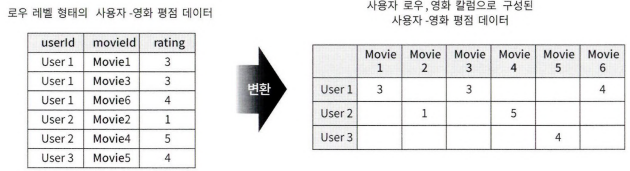

* `pivot_table()` : row 레벨의 값을 column으로 변경하는 함수.
  * `columns='movieId'` : `movieId` column의 모든 값이 새로운 column 이름으로 변환된다.

`ratings.pivot_table('rating', index='userId', columns='movieId')` : row 레벨은 `userId`, column은 모두 `movieId` column에 있는 값으로 column 이름으로 바뀌고, 데이터는 `rating` 칼럼에 있는 값이 할당된다.

In [3]:
ratings=ratings[['userId', 'movieId', 'rating']]
ratings_matrix=ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


① `NaN` 값이 많은 이유는 사용자가 평점을 매기지 않은 영화가 칼럼으로 변환되었기 때문이다.

➡️최소 평점이 0.5이므로 `NaN`은 모두 0으로 변환한다.

② `movieId` ➡ `title`
* 영화명(`title`)은 `ratings`에 존재하지 않고 `movies` 데이터 세트에 존재한다.
  * `ratings`와 `movies`를 조인해 `title` 칼럼을 가져온 뒤 `pivot_table()`의 인자로 columns에 '`movieId`'가 아닌 '`title`'을 입력해 `title`로 피벗(pivot)한다.
  * `NaN`은 0으로 변환한다.

In [4]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies=pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 피벗 수행
ratings_matrix=rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix=ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **영화 간 유사도 산출**

코사인 유사도를 기반으로 한다.
* `cosine_similarity()` : row를 기준으로 서로 다른 row를 비교해 유사도를 산출한다.

⚠ `ratings_matrix` 데이터 세트에 `cosine_similarity()`를 적용하면 영화간 유사도를 측정할 수 없다. `ratings_matrix`는 `userId`가 기준인 row 레벨 데이터이므로 여기에 `cosine_similarity()`를 적용하면 영화 간의 유사도가 아닌 사용자 간의 유사도가 만들어진다.

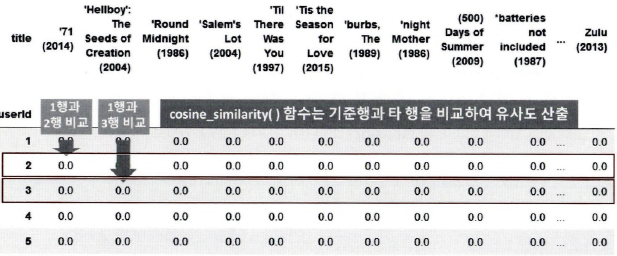

➡ row와 column의 위치를 변경한다.
* `transpose()`

In [5]:
ratings_matrix_T=ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`cosine_similarity()`로 반환된 넘파이 행렬에 영화명을 매핑해 DataFrame으로 변환한다.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim=cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df=pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                         columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


영화 '대부'와 유사도가 높은 상위 6개 영화 추출

In [8]:
item_sim_df['Godfather, The (1972)'].sort_values(ascending=False)[:6]

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


'대부-2편'이 가장 유사도가 높다.

앞의 콘텐츠 기반 필터링과 다른 점은 '뻐꾸기 둥지 위로 날아간 새', '스타워즈 1편'과 같이 장르가 완전히 다른 영화도 유사도가 매우 높게 나타났다는 것이다.

영화 '인셉션'과 유사도가 높은 상위 6개 영화 추출

In [9]:
item_sim_df['Inception (2010)'].sort_values(ascending=False)[1:6]

,Inception (2010)
title,
"Dark Knight, The (2008)",0.727263
Inglourious Basterds (2009),0.646103
Shutter Island (2010),0.617736
"Dark Knight Rises, The (2012)",0.617504
Fight Club (1999),0.615417


'다크나이트'가 가장 유사도가 높다. 주로 스릴러와 액션이 가미된 영화가 높은 유사도를 나타낸다.

아이템 기반 유사도 데이터는 사용자의 평점 정보를 모두 취합해 영화에 따라 유사한 다른 영화를 추천할 수 있게 해준다.

## **아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천**

* 아이템 기반의 영화 유사도 데이터 : 모든 사용자의 평점을 기준으로 영화의 유사도를 생성하여 추천한다.
  * 개인적인 취향을 반영하지 않고 영화 간의 유사도만을 가지고 추천한다.

* 영화 유사도 데이터 이용. 최근접 이웃 협업 필터링, **개인에게 최적화된 영화 추천**.
  * 개인이 아직 관람하지 않은 영화 추천. **아직 관람하지 않은 영화에 대한 아이템 유사도**와 **관람한 영화의 평점 데이터**를 기반으로 새롭게 모든 영화를 예측 평점을 계산한 후 높은 예측 평점을 가진 영화를 추천한다.
  * 개인화된 예측 평점 식

  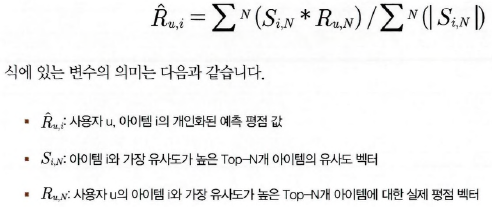

$S_{i, N}$, $R_{u, N}$에 나오는 $N$ 값은 아이템의 최근접 이웃 범위 계수(item neighbor)를 의미한다. 이는 특정 아이템과 유사도가 가장 높은 Top-N개의 다른 아이템을 추출하는 데 사용된다.

$N$의 범위에 제약을 두지 않고 예측 평점을 구하는 로직을 작성한 뒤, Top-N 아이템을 기반으로 협업 필터링을 수행하는 로직으로 변경한다.

영화 간 유사도 DataFrame인 `item_sim_df`와 사용자-영화 평점 DataFrame인 `ratings_matrix` 변수를 활용해 사용자별로 최적화된 평점 스코어를 예측하는 함수를 만든다.
* 함수명 : `predict_rating()`
* 인자 : 사용자-영화 평점 행렬(`rating_matrix`) 넘파이 행렬, 영화 간의 유사도 행렬(`item_sim_df`) 넘파이 행렬
  * 넘파이 행렬로 변환 필요
* 위 식을 이용해 개인화된 예측 평점을 계산한다.

$N$의 범위에 제약을 두지 않으면
* $R_{u, N}$ : 사용자 u의 모든 영화에 대한 실제 평점
* $S_{i, N}$ : 영화 i의 다른 모든 영화와의 코사인 유사도

In [10]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred=ratings_arr.dot(item_sim_arr)/np.array([np.abs(item_sim_arr).sum(axis=1)])
  return ratings_pred

`predict_rating()` 함수를 이용해 개인화된 예측 평점을 구한다.

In [11]:
ratings_pred=predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix=pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                 columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


원래의 실제 평점과 얼마나 차이가 있는지 확인한다.
* 예측 평가 지표 : MSE
  * `get_mse()` 함수

⚠ 사용자가 영화의 평점을 주지 않은 경우에 대해서도 아이템 유사도에 기반해 평점을 예측했다. 따라서 실제와 예측 평점의 차이는 기존에 평점이 부여된 데이터에 대해서만 측정한다.

In [12]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 구함.
def get_mse(pred, actual):
  # 평점이 있는 실제 영화만 추출
  pred=pred[actual.nonzero()].flatten()
  actual=actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE :', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE : 9.895354759094706


많은 영화의 유사도 벡터를 이용하다 보니 상대적으로 평점 예측이 떨어졌다. 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터를 적용하는 함수로 변경한다.
* `predict_rating_topsim(ratings_arr, item_sim_arr, n=20)` : n 인자를 가지고 있어서 Top-N 유사도를 가지는 영화 유사도 벡터만 예측값을 계산하는 데 적용한다.

In [15]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
  # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
  pred=np.zeros(ratings_arr.shape)

  # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
  for col in range(ratings_arr.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
    top_n_items=[np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
    # 개인화된 예측 평점을 계산
    for row in range(ratings_arr.shape[0]):
      pred[row, col]=item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
      pred[row, col]/=np.sum(np.abs(item_sim_arr[col, :][top_n_items]))

  return pred

`predict_rating_topsim()` 함수를 이용해 예측 평점을 계산하고, 실제 평점과의 MSE를 구해 보자.

계산된 예측 평점 넘파이 행렬은 판다스 DataFrame으로 재생성한다.

In [16]:
ratings_pred=predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)
print('아이템 기반 최근접 Top-20 이웃 MSE :', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix=pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                 columns=ratings_matrix.columns)

<ipython-input-15-17043ec15487>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[row, col]=item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)


아이템 기반 최근접 Top-20 이웃 MSE : 3.6949827608772314


`userId=9`인 사용자에 대해 영화를 추천한다.

① 9번 `userId` 사용자가 어떤 영화를 좋아하는지 확인한다. 사용자가 평점을 준 영화를 평점이 높은 순으로 나열한다.

In [17]:
user_rating_id=ratings_matrix.loc[9, :]
user_rating_id[user_rating_id>0].sort_values(ascending=False)[:10]

,9
title,
Adaptation (2002),5.0
Citizen Kane (1941),5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),5.0
"Producers, The (1968)",5.0
"Lord of the Rings: The Two Towers, The (2002)",5.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",5.0
Back to the Future (1985),5.0
Austin Powers in Goldmember (2002),5.0
Minority Report (2002),4.0


'반지의 제왕', '오스틴 파워' 등 대작 영화, 어드벤처 영화, 코미디 영화 등 전반적으로 흥행이 좋은 영화에 높은 평점을 주고 있다.

② 아이템 기반 협업 필터링을 통해 영화를 추천한다.
  * 'get_unseen_movies()` : 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수

In [18]:
def get_unseen_movies(ratings_matrix, userId):
  # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임.
  user_rating=ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦.
  already_seen=user_rating[user_rating>0].index.tolist()

  # 모든 영화명을 list 객체로 만듦.
  movies_list=ratings_matrix.columns.tolist()

  # list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함.
  unseen_list=[movie for movie in movies_list if movie not in already_seen]

  return unseen_list

③ `recomm_movie_by_userid()` : 사용자가 영화의 평점을 주지 않은 추천 대상 영화 정보와 `predict_rating_topsim()`에서 추출한 사용자별 아이템 유사도에 기반한 예측 평점 데이터 세트를 이용해 사용자에게 영화를 추천하는 함수.
  * 인자 : 예측평점 DataFrame, 사용자id, 추천 후보 영화 리스트, 추천 상위 영화 개수

In [19]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
  # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
  # 가장 예측 평점이 높은 순으로 정렬
  recomm_movies=pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
  return recomm_movies

# 사용자가 관람하지 않은 영화명 추출
unseen_list=get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies=recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies=pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                           columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


'슈렉', '스파이더 맨', '인디아나 존스-2편', '매트릭스' 등 다양하지만 높은 흥행성을 가진 작품

# **07. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**

* 행렬 분해 잠재 요인 협업 필터링 : SVD, NMF 적용 가능

⚠ 보통 SVD가 자주 사용되지만 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 **Null 데이터가 많기 때문에** 주로 **SGD나 ALS 기반의 행렬 분해**를 이용한다.

SGD 기반의 행렬 분해를 구현하고 이를 기반으로 사용자에게 영화를 추천한다.

확률적 경사 하강법을 이용한 행렬 분해 이용(4절)
* `matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01)`
  * `R` : 원본 사용자-아이템 평점 행렬
  * `K` : 잠재 요인의 차원 수
  * `steps` : SGD의 반복 횟수
  * `learning_rate` : 학습률
  * `r_lambda` : L2 규제 계수

In [25]:
def get_rmse(R, P, Q, non_zeros):
  error=0
  # 두 개의 분해된 행렬 P, Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix=np.dot(P, Q.T)

  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스를 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind=[non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind=[non_zero[1] for non_zero in non_zeros]
  R_non_zeros=R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros=full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse=mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse=np.sqrt(mse)

  return rmse

In [27]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):
  num_users, num_items=R.shape
  # P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤한 값으로 입력한다.
  np.random.seed(1)
  P=np.random.normal(scale=1./K, size=(num_users, K))
  Q=np.random.normal(scale=1./K, size=(num_items, K))

  # R > 0인 행 위치, 열 위치, 값을 non_zeros 리스트 객체 저장
  non_zeros=[(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]

  # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
  for step in range(steps):
    for i, j, r in non_zeros:
      # 실제 값과 예측 값의 차이의 오류 값
      eij=r-np.dot(P[i, :], Q[j, :].T)
      # Regularization을 반영한 SGD 업데이트 공식 적용
      P[i, :]=P[i, :]+learning_rate*(eij*Q[j, :]-r_lambda*P[i, :])
      Q[j, :]=Q[j, :]+learning_rate*(eij*P[i, :]-r_lambda*Q[j, :])

    rmse=get_rmse(R, P, Q, non_zeros)
    if (step % 10) == 0:
      print('### iteration step :', step, 'rmse :', rmse)

  return P, Q

사용자-평점 행렬

In [28]:
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


행렬 분해 : `matrix_factorization()`
* `steps` : 200회
* `K` : 50
* `learning_rate` : 0.01
* `r_lambda` : 0.01

In [29]:
P, Q=matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01,
                          r_lambda=0.01)
pred_matrix=np.dot(P, Q.T)

### iteration step : 0 rmse : 2.9023619751336867
### iteration step : 10 rmse : 0.7335768591017927
### iteration step : 20 rmse : 0.5115539026853442
### iteration step : 30 rmse : 0.37261628282537446
### iteration step : 40 rmse : 0.2960818299181014
### iteration step : 50 rmse : 0.2520353192341642
### iteration step : 60 rmse : 0.22487503275269854
### iteration step : 70 rmse : 0.2068545530233154
### iteration step : 80 rmse : 0.19413418783028685
### iteration step : 90 rmse : 0.18470082002720406
### iteration step : 100 rmse : 0.17742927527209104
### iteration step : 110 rmse : 0.1716522696470749
### iteration step : 120 rmse : 0.16695181946871726
### iteration step : 130 rmse : 0.16305292191997542
### iteration step : 140 rmse : 0.15976691929679646
### iteration step : 150 rmse : 0.1569598699945732
### iteration step : 160 rmse : 0.15453398186715425
### iteration step : 170 rmse : 0.15241618551077643
### iteration step : 180 rmse : 0.1505508073962831
### iteration step : 190 rmse : 

예측 사용자-아이템 평점 행렬 ➡ 영화 아이템 칼럼
* 영화 타이틀을 칼럼명으로 가지는 DataFrame으로 변경

In [31]:
ratings_pred_matrix=pd.DataFrame(data=pred_matrix, index=ratings_matrix.index,
                                 columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


`get_unseen_movies()`, `recomm_movie_by_userid()` (9.6절)

In [32]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list=get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies=recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies=pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                           columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


* 아이템 기반 협업 필터링 : '슈렉', '스파이더 맨', '인디아나 존스-2편', '매트릭스' 등 다양하지만 높은 흥행성을 가진 작품
* '이창(스릴러 영화)', '사우스파크(어른을 위한 애니메이션)', '라운더스(도박 영화)', '블레이드 러너', '로저와 나', '가타카' 약간 어둡고 무거운 주제의 영화

# **08. 파이썬 추천 시스템 패키지 - `Surprise`**

## **`Surprise` 패키지 소개**

`Surprise` : 파이썬 기반의 추천 시스템 구축을 위한 전용 패키지 중 하나.
* 파이썬 기반에서 사이킷런과 유사한 API와 프레임워크를 제공한다.
  * `fit()` : 추천 데이터 학습
  * `predict()` : 예측
  * `train_test_split()` : 추천 학습 데이터 세트와 예측 데이터 세트 분리
  * `cross_validate()`, `GridSearchCV` : 추천 시스템을 위한 모델 셀렉션, 평가, 하이퍼 파라미터 튜닝 등의 기능
* 다양한 추천 알고리즘 : 사용자/아이템 기반 최근접 이웃 협업 필터링, SVD, SVD++, NMF 기반의 잠재 요인 협업 필터링을 쉽게 적용해 추천 시스템을 구축할 수 있다.
* 데이터 로딩은 `Dataset` 클래스를 이용해서만 가능하다.
* row 레벨 형태로 돼있는 포맷의 데이터만 처리한다.

In [33]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357268 sha256=8f3c063a9d82cb70a1ffb926af13b173aa49515e2b07d52bc46ce2fb7ec68976
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **`Surprise`를 이용한 추천 시스템 구축**

추천 데이터를 학습용과 테스트용 데이터 세트로 분리한 뒤 SVD 행렬 분해를 통한 잠재 요인 협업 필터링을 수행한다.

In [34]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

① 데이터 세트 로딩
  * `load_builtin()` : 무비렌즈 사이트에서 제공하는 과거 버전 데이터 세트인 'ml-100k'(10만 개 평점 데이터)
    * 분리 문자 탭(\t)

② `train_test_split()` API : 학습 데이터 세트와 테스트 데이터 세트로 분리한다.

In [35]:
data=Dataset.load_builtin('ml-100k')

# 수행 시마다 동일하게 데이터를 분리하기 위해 random_state 값 부여
trainset, testset=train_test_split(data, test_size=.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


③ SVD로 잠재 요인 협업 필터링 수행
  1. `algo=SVD()` : 알고리즘 객체 생성
  2. `fit(학습 데이터 세트)` : 알고리즘 객체에 수행해 학습 데이터 세트 기반으로 추천 알고리즘 학습

In [36]:
algo=SVD(random_state=0)
algo.fit(trainset)

④ 학습된 추천 알고리즘을 기반으로 테스트 데이터 세트에 대한 추천을 수행한다.
  * `test()` : 사용자-아이템 평점 데이터 세트 전체에 대해 추천 예측. 입력된 데이터 세트에 대해 추천 데이터 세트를 만들어 준다.
  * `predict()` : 개별 사용자와 영화에 대한 추천 평점 반환

**1. `test()` 사용**

In [37]:
predictions=algo.test(testset)
print('prediction type :', type(predictions), 'size :', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type : <class 'list'> size : 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

25,000개의 Prediction 객체를 가지고 있다.
* Prediction 객체 : `Surprise` 패키지에서 제공하는 데이터 타입
  * `uid` : 개별 사용자 아이디
  * 영화(또는 아이템)
  * `iid` : 아이디
  * `r_ui` : 실제 평점
  * `est` : `Surprise`의 추천 예측 평점 (튜플 형태)
  * `details` : 내부 처리 시 추천 예측을 할 수 없는 경우 로그용으로 데이터를 남기는 데 사용
    * `was_impossible` : True이면 예측값을 생성할 수 없는 데이터라는 의미이다.
  * 속성에 접근하려면 `객체명.uid`

In [38]:
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

**2. `predict()` 사용**
* 개별 사용자 아이디, 아이템 아이디를 입력하면 추천 예측 평점을 포함한 정보를 반환한다.
  * 기존 평점 정보(`r_ui`)는 선택 사항이며, 사용자 아이디, 아이템 아이디는 문자열로 입력해야 한다.

In [39]:
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함
uid=str(196)
iid=str(302)
pred=algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


개별 사용자와 아이템 정보를 입력하면 추천 예측 평점을 `est`로 반환한다.

`test()` 메서드는 입력 데이터 세트의 모든 사용자와 아이템 아이디에 대해서 `predict()`를 반복적으로 수행한 결과이다.

⑤ 테스트 데이터 세트를 이용해 추천 예측 평점과의 차이를 평가한다.
  * `accuracy` : RMSE, MSE 등의 방법으로 추천 시스템의 성능 평가 정보를 제공한다.

In [40]:
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

## **`Surprise` 주요 모듈 소개**

### **Dataset**

* `user_id`(사용자 아이디), `item_id`(아이템 아이디), `rating`(평점) 데이터가 row 레벨로 된 데이터 세트만 적용할 수 있다.

* 일반 데이터 파일, 판다스 DataFrame에서도 로딩할 수 있다. 단, 데이터 세트의 칼럼 순서가 사용자 아이디, 아이템 아이디, 평점 순으로 반드시 돼 있어야 한다.

1. `Dataset.load_builtin(name='nl-100k')` : `.surprise_data` 디렉터리 밑에 저장됨.
2. `Dataset.load_from_file(file_path, reader)` : OS 파일에서 데이터를 로딩할 때 사용. 콤마, 탭 등으로 칼럼이 분리된 포맷의 OS 파일에서 데이터 로딩. 입력 파라미터로 OS 파일명, Reader로 파일의 포맷 지정
3. `Dataset.load_from_df(df, reader)` : 판다스의 DataFrame에서 데이터를 로딩한다. 파라미터로 DataFrame을 입력받으며 DataFrame 역시 반드시 3개의 칼럼인 사용자 아이디, 아이템 아이디, 평점 순으로 칼럼 순서가 정해져 있어야 한다. 입력 파라미터로 DataFrame 객체, Reader로 파일의 포맷을 지정한다.

### **OS 파일 데이터를 `Surprise` 데이터 세트로 로딩**

① 데이터 세트 로딩

2. `Data.load_from_file(file_path, reader)` API 이용 시

⚠ 헤더 삭제해야 함.

In [41]:
import pandas as pd

ratings=pd.read_csv('/content/drive/MyDrive/24-2/ESAA/과제/ml-latest-small/ratings.csv')

# ratings_noh.csv 파일로 업로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성.
ratings.to_csv('ratings_noh.csv', index=False, header=False)

`Dataset.load_from_file()`을 적용하기 전에 `Reader` 클래스를 이용해 데이터 **파일의 파싱 포맷**을 정의해야 한다.

`ratings_noh.csv` : column 헤더가 없고, 4개의 칼럼이 콤마로만 분리돼 있다.

`Reader` 클래스의 생성자에 각 필드의 칼럼명과 칼럼 분리문자, 최소~최대 평점을 입력해 객체를 생성하고, `load_from_file()`로 생성된 `Reader` 객체를 참조해 데이터 파일을 파싱하면서 로딩한다.

In [42]:
from surprise import Reader

reader=Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data=Dataset.load_from_file('/content/ratings_noh.csv', reader=reader)

`Surprise` 데이터 세트는 무비렌즈 데이터 형식을 따르므로 무비렌즈 데이터 형식이 아닌 다른 OS 파일일 경우 `Reader` 클래스를 먼저 설정해야 한다.
* `line_format(string)` : 칼럼을 순서대로 나열한다. 입력된 문자열을 공백으로 분리해 칼럼으로 인식한다.
* `sep(char)` : 칼럼을 분리하는 분리자이다.
  * 디폴트 : '\t'
  * 판다스 DataFrame에서 입력받을 경우, 기재할 필요가 없다.
* `rating_scale(tuple, optional)` : 평점 값의 최소~최대 평점 설정
  * 디폴트 : (1, 5)
  * `ratings.csv` 파일의 경우 최소 평점이 0.5, 최대 평점이 5이므로 (0.5, 5)

② `train_test_split()` API : 학습 데이터 세트와 테스트 데이터 세트로 분리한다.

③ SVD 행렬 분해 기법을 이용해 추천 예측
  * `n_factors` : 50

④ 학습된 추천 알고리즘을 기반으로 테스트 데이터 세트에 대한 추천을 수행한다.

⑤ 테스트 데이터 세트를 이용해 추천 예측 평점과의 차이를 평가한다.

In [43]:
trainset, testset=train_test_split(data, test_size=.25, random_state=0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo=SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions=algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

### **판다스 DataFrame에서 `Surprise` 데이터 세트로 로딩**

3. `Dataset.load_from_df(df, reader)` 이용 시

In [44]:
import pandas as pd
from surprise import Reader, Dataset

ratings=pd.read_csv('/content/drive/MyDrive/24-2/ESAA/과제/ml-latest-small/ratings.csv')
reader=Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 한다.
data=Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset=train_test_split(data, test_size=.25, random_state=0)

algo=SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions=algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

## **`Surprise` 추천 알고리즘 클래스**

`Surprise`에서 추천 예측을 위해 자주 사용되는 추천 알고리즘 클래스

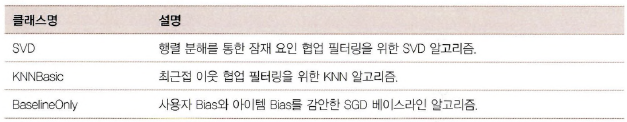

`Surprise SVD`의 비용 함수는 ❓사용자 베이스라인 편향성을 감안한 평점 예측에 Regularization을 적용한 것이다.

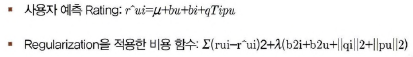

`SVD` 클래스의 입력 파라미터

* `n_factors`, `n_epochs` 값을 변경해 튜닝할 수 있으나, 효과는 크지 않다.
* `biased`는 True로 설정을 유지하는 것이 좋다.

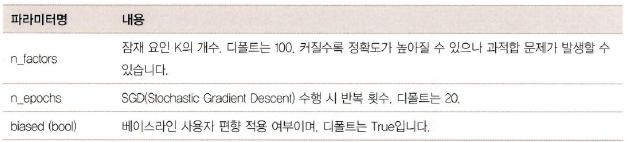

`SVD++` > `SVD` > `k-NN Baseline`
* `SVD++` : 시간이 오래 걸림
* Baseline : 각 개인이 평점을 부여하는 성향을 반영해 평점을 계산하는 방식.

## **베이스라인 평점**

각 개인의 성향에 따라 같은 아이템이더라도 평가가 달라질 수 있다.

베이스라인 평점(Baseline Rating) : 개인의 성향을 반영해 아이템 평가에 편향성(bias) 요소를 반영하여 평점을 부과하는 것

* 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수
  * 전체 평균 평점 : 모든 사용자의 평점을 평균한 값
  * 사용자 편향 점수 : 사용자 평점 평균 값 - 전체 평균 평점
  * 아이템 편향 점수 : 아이템별 평점 평균 값 - 전체 평균 평점

모든 사용자의 평균적인 영화 평점이 3.5이고, '어벤저스 3편'을 모든 사용자가 평균적으로 평점 4.2로 평가했다면 영화 (평가를 늘 깐깐하게 하는) 사용자 A가 '어벤저스 3편'을 어떻게 평가할 것인지 예상해 보자.

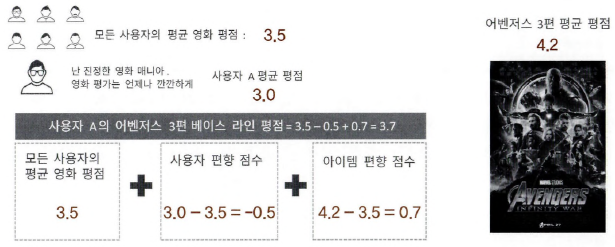

사용자 A의 '어벤저스 3'의 베이스라인 평점은 3.7

## **교차 검증과 하이퍼 파라미터 튜닝**

`cross_validate()` : `surprise.model_selection` 모듈 내에 존재. 폴드된 데이터 세트의 개수와 성능 측정 방법을 명시해 교차 검증 수행

①`cross_validate()`으로 5개의 학습/검증 폴드 데이터 세트로 분리해 교차 검증을 수행하고 ②RMSE, MAE로 성능 평가를 진행한다.
* 인자 : 알고리즘 객체, 데이터, 성능 평가 방법(measures), 폴드 데이터 세트 개수(cv)

In [46]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings=pd.read_csv('/content/drive/MyDrive/24-2/ESAA/과제/ml-latest-small/ratings.csv')
reader=Reader(rating_scale=(0.5, 5.0))
data=Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo=SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8688  0.8809  0.8679  0.8758  0.8726  0.8732  0.0048  
MAE (testset)     0.6697  0.6765  0.6686  0.6715  0.6695  0.6712  0.0028  
Fit time          1.82    2.71    2.20    2.28    2.46    2.29    0.29    
Test time         0.14    0.56    0.28    0.14    0.17    0.26    0.16    


{'test_rmse': array([0.86875695, 0.88092589, 0.86790862, 0.87578182, 0.87258328]),
 'test_mae': array([0.66974362, 0.67645239, 0.66859186, 0.67147973, 0.6695167 ]),
 'fit_time': (1.8161768913269043,
  2.7079646587371826,
  2.20416522026062,
  2.2799384593963623,
  2.4583280086517334),
 'test_time': (0.13803505897521973,
  0.5608963966369629,
  0.27547597885131836,
  0.1447746753692627,
  0.16874289512634277)}

`cross_validate()`는 폴드별 성능 평가 수치, 전체 폴드의 평균 성능 평가 수치를 함께 보여준다.

`Surprise`의 `GridSearchCV`도 사이킷런과 유사하게 교차 검증을 통한 하이퍼 파라미터 최적화를 수행한다.
* `cv=3`

SVD 클래스의 파라미터
* `n_factors` : 점진적 하강 방식의 반복 횟수
  * `[50, 100, 200]`
* `n_epochs` : `SVD`의 잠재 요인 `K`의 크기
  * `[20, 40, 60]`

In [47]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정
param_grid={'n_epochs' : [20, 40, 60], 'n_factors' : [50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mae로 수행하도록 GridSearchCV 구성
gs=GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8776388808022743
{'n_epochs': 20, 'n_factors': 50}


## **`Surprise`를 이용한 개인화 영화 추천 시스템 구축**

`ratings.csv` 데이터를 학습 데이터와 테스트 데이터로 분리하지 않고 전체를 학습 데이터로 사용한다.

⚠ `Surprise`는 데이터 세트를 `train_test_split()`을 이용해 내부에서 사용하는 `TrainSet` 클래스 객체로 변환하지 않으면 `fit()`을 통해 학습할 수 없다.

데이터 세트 전체를 학습 데이터로 사용하려면 DatasetAutoFolds 객체를 생성한 뒤에 `build_full_trainset()` 메서드를 호출한다.

In [48]:
from surprise.dataset import DatasetAutoFolds

reader=Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))

# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds=DatasetAutoFolds(ratings_file='/content/ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 생성
trainset=data_folds.build_full_trainset()

In [49]:
algo=SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

`userId` 9가 아직 평점을 매기지 않은 영화 `movieId 42`에 대한 예측 평점을 계산한다.

In [51]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies=pd.read_csv('/content/drive/MyDrive/24-2/ESAA/과제/ml-latest-small/movies.csv')

# userId=9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds=ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count()==0:
  print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


`predict()` 메서드 내에서 `userId`, `movieId` 값 입력. 문자열 값이어야 함.

In [52]:
uid=str(9)
iid=str(42)

pred=algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


추천 예측 평점은 `est` : 3.13

사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤 예측 평점 순으로 영화를 추천한다.

① 추천 대상 영화 추출

In [55]:
def get_unseen_surprise(ratings, movies, userId):
  # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
  seen_movies=ratings[ratings['userId']==userId]['movieId'].tolist()

  # 모든 영화의 movieId를 리스트로 생성
  total_movies=movies['movieId'].tolist()

  # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
  unseen_movies=[movie for movie in total_movies if movie not in seen_movies]
  print('평점 매긴 영화 수 :', len(seen_movies), '추천 대상 영화 수 :', len(unseen_movies),
        '전체 영화 수 :', len(total_movies))

  return unseen_movies

unseen_movies=get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수 : 46 추천 대상 영화 수 : 9696 전체 영화 수 : 9742


② SVD를 이용해 높은 예측 평점을 가진 순으로 영화를 추천한다.

`recomm_movie_by_surprise()` 인자
* 학습이 완료된 추천 알고리즘 객체
* 추천 대상 사용자 아이디
* 추천 대상 영화의 리스트 객체
* 추천 상위 N개 개수

In [56]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
  # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
  predictions=[algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
  # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]

  # 이를 est 값으로 정렬하기 위해 아래의 sortkey_est 함수 정의
  # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행
  def sortkey_est(pred):
    return pred.est

  # sortkey_est() 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출
  predictions.sort(key=sortkey_est, reverse=True)
  top_predictions=predictions[:top_n]

  # top_n으로 추출된 영화의 정보 추출, 영화 아이디, 추천 예상 평점, 제목 추출
  top_movie_ids=[int(pred.iid) for pred in top_predictions]
  top_movie_rating=[pred.est for pred in top_predictions]
  top_movie_titles=movies[movies.movieId.isin(top_movie_ids)]['title']

  top_movie_preds=[(id, title, rating) for id, title, rating in
                   zip(top_movie_ids, top_movie_titles, top_movie_rating)]
  return top_movie_preds

unseen_movies=get_unseen_surprise(ratings, movies, 9)
top_movie_preds=recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)

print('#### Top-10 추천 영화 리스트 ####')
for top_movie in top_movie_preds:
  print(top_movie[1], ':', top_movie[2])

평점 매긴 영화 수 : 46 추천 대상 영화 수 : 9696 전체 영화 수 : 9742
#### Top-10 추천 영화 리스트 ####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957


'유주얼 서스펙트', '펄프픽션', '양들의 침묵', '대부', '좋은 친구들' 같은 서스펜스/스릴러/범죄 영화 및 스타워즈와 같은 액션 영화 등이 주로 추천됐다.

`Surprise` 패키지는 복잡한 알고리즘을 직접 구현하지 않고도 쉽고 간결한 API를 이용해 파이썬 기반에서 추천 시스템을 구축할 수 있도록 해준다.

# **09. 정리**

1. 콘텐츠 기반 필터링 : 아이템(상품, 영화, 서비스 등)을 구성하는 여러 가지 콘텐츠 중 사용자가 좋아하는 콘텐츠를 필터링하여 이에 맞는 아이템을 추천하는 방식
  * 영화 추천 : 사용자가 좋아하는 영화를 분석한 뒤, 이 영화의 콘텐츠와 유사한 다른 영화 추천. 요소들을 결합하여 하나의 콘텐츠 특징으로 피처 벡터화한 뒤 피처 벡터와 가장 유사한 다른 피처 벡터를 가진 영화를 추천한다.
    * 콘텐츠 : 장르, 감독, 영화배우, 영화 키워드
2. 협업 필터링
  
  ① 최근접 이웃 협업 필터링
    * 사용자 기반(사용자-사용자)
    * 아이템 기반(아이템-아이템) : 더 많이 사용됨. 특정 아이템과 가장 근접하게 유사한 다른 아이템들을 추천하는 방식.
      * 유사도의 기준 : 사용자들의 아이템에 대한 평가를 벡터화한 값.
      * 모든 아이템을 행으로, 모든 사용자를 열로, 사용자별-아이템 평점을 값으로 하는 아이템-사용자 행렬 데이터 세트를 만들고, 아이템별로 코사인 유사도를 이용해 사용자 평점 피처 벡터에 따른 Top-N 유사 아이템을 추천한다.
  
  ② 잠재 요인 협업 필터링 : 많은 추천 시스템에서 이용. 사용자-아이템 평점 행렬 데이터에 숨어 있는 잠재 요인을 추출하여 사용자가 아직 평점을 매기지 않은 아이템에 대한 평점을 예측하여 이를 추천에 반영하는 방식.
  * 행렬 분해 : 잠재 요인을 추출하기 위해 다차원의 사용자-아이템 평점 행렬을 저차원의 사용자-잠재요인, 아이템-잠재요인 행렬로 분해한다.
    * 행렬 분해 기법을 경사 하강법으로 구현한다.

`Surprise` : 파이썬의 추천 시스템 패키지 중 하나
